In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install SAM and necessary dependencies
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.5 MB/s eta 0:00:00


In [3]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import supervision as sv
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

torch.cuda.is_available()

True

In [4]:
# CHECKPOINT downloading
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-07-22 09:36:59--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.165.83.79, 18.165.83.44, 18.165.83.91, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.165.83.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   117MB/s    in 21s     

2024-07-22 09:37:20 (117 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [5]:
# Define model type and checkpoint path
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/content/sam_vit_h_4b8939.pth"

# Load the model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Init mask generator
mask_generator = SamAutomaticMaskGenerator(sam)

/content/drive/MyDrive/KernelGAN-Masks/imgs/img10
(1536, 2040)
(768, 1020)
(1536, 2040)
(768, 1020)
/content/drive/MyDrive/KernelGAN-Masks/masks/img10/back_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img10/back_lr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img10/obj_hr_mask.png
/content/drive/MyDrive/KernelGAN-Masks/masks/img10/obj_lr_mask.png


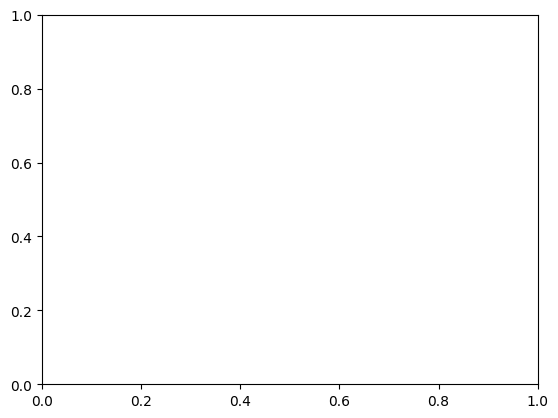

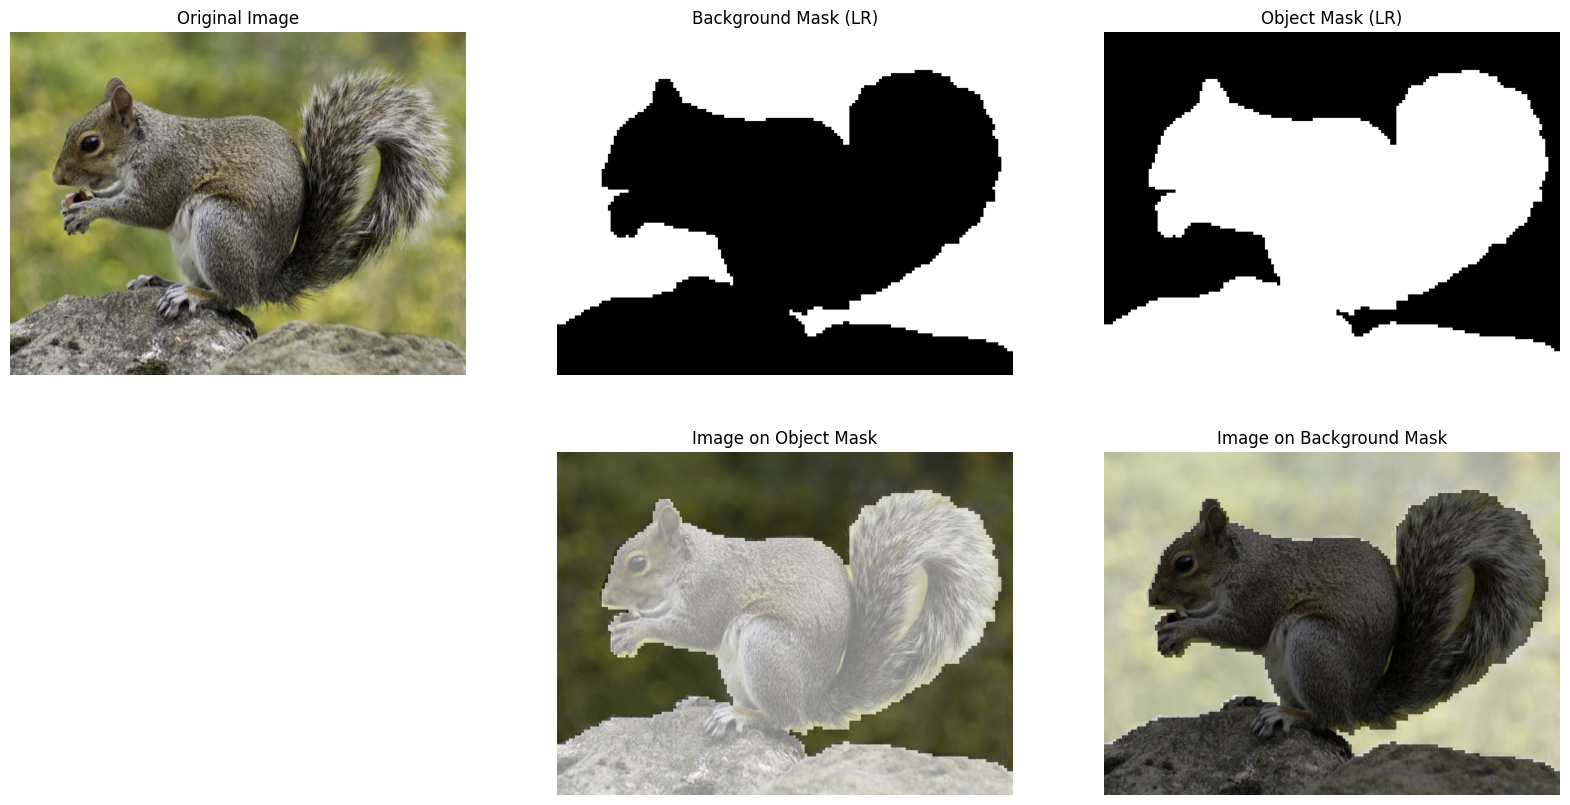

In [8]:
# def create_blocky_mask(img):
#     scale_factor = 0.2
#     small_lr_back = cv2.resize(img, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)
#     blocky_lr_back = cv2.resize(small_lr_back, img.shape[::-1], interpolation=cv2.INTER_NEAREST)
#     return blocky_lr_back

def create_blocky_mask(img):
    scale_factor = 0.15
    _, binary_mask = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    small_lr_back = cv2.resize(binary_mask, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)
    blocky_lr_back = cv2.resize(small_lr_back, img.shape[::-1], interpolation=cv2.INTER_NEAREST)
    return blocky_lr_back

def extract_numbers_from_filename(filename):
    match = re.search(r'\d+', filename)
    if match:
        return int(match.group())
    else:
        return None

def create_masks(result_dict, axes=None, masks_num=None):
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    if not masks_num:
        masks_num = len(result_dict)
    sorted_result = sorted(result_dict, key=lambda x: x['area'], reverse=True)
    sorted_result = sorted_result[:masks_num]
    return sorted_result

def extract_largest_component(mask):
    true_map_binary = (mask * 255).astype(np.uint8)
    kernel = np.ones((10, 10), np.uint8)
    true_map_binary = cv2.morphologyEx(true_map_binary, cv2.MORPH_CLOSE, kernel)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(true_map_binary)
    largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    largest_component_mask = (labels == largest_component).astype(np.uint8) * 255
    return largest_component_mask

def create_mask(image_path):
    image_rgb = cv2.imread(image_path)
    output_mask = mask_generator.generate(image_rgb)
    masks = create_masks(output_mask)
    mask = masks[0]['segmentation']
    largest_component_mask = extract_largest_component(mask)
    return largest_component_mask

# do the code above for all the imgs in the src folder
base = "/content/drive/MyDrive/KernelGAN-Masks"
src = base + "/imgs"
dst = base + "/masks"

files = os.listdir(src)

for file_name in files:
    image_path = os.path.join(src, file_name)
    img_num = extract_numbers_from_filename(file_name)
    dir_path = os.path.join(dst, 'img' + str(img_num))
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
    print(image_path)

    for img in os.listdir(image_path):
        if "lr" in img:
            image_path_lr = os.path.join(image_path, img)
            break

    lr_back = create_mask(image_path_lr)
    new_path_back_hr = os.path.join(dir_path, "back_hr_mask.png")
    new_path_back_lr = os.path.join(dir_path, "back_lr_mask.png")
    new_path_obj_hr = os.path.join(dir_path, "obj_hr_mask.png")
    new_path_obj_lr = os.path.join(dir_path, "obj_lr_mask.png")

    hr_back = cv2.resize(lr_back, dsize=(lr_back.shape[1]*2, lr_back.shape[0]*2), interpolation=cv2.INTER_CUBIC)
    hr_obj = cv2.bitwise_not(hr_back)
    lr_obj = cv2.bitwise_not(lr_back)

    cv2.imwrite(new_path_back_hr, create_blocky_mask(hr_back))
    cv2.imwrite(new_path_back_lr, create_blocky_mask(lr_back))
    cv2.imwrite(new_path_obj_hr, create_blocky_mask(hr_obj))
    cv2.imwrite(new_path_obj_lr, create_blocky_mask(lr_obj))
    #print the shape of the new imgs
    print(hr_back.shape)
    print(lr_back.shape)
    print(hr_obj.shape)
    print(lr_obj.shape)

    print(new_path_back_hr)
    print(new_path_back_lr)
    print(new_path_obj_hr)
    print(new_path_obj_lr)

   # Plotting the images and masks
    original_image = cv2.imread(image_path_lr)
    back_lr_mask = cv2.imread(new_path_back_lr, cv2.IMREAD_GRAYSCALE)
    obj_lr_mask = cv2.imread(new_path_obj_lr, cv2.IMREAD_GRAYSCALE)

    # Creating overlays
    back_overlay = cv2.addWeighted(original_image, 0.5, cv2.cvtColor(back_lr_mask, cv2.COLOR_GRAY2BGR), 0.5, 0)
    obj_overlay = cv2.addWeighted(original_image, 0.5, cv2.cvtColor(obj_lr_mask, cv2.COLOR_GRAY2BGR), 0.5, 0)

    plt.figure(figsize=(20, 10))

    plt.subplot(2, 3, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.title('Background Mask (LR)')
    plt.imshow(back_lr_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.title('Object Mask (LR)')
    plt.imshow(obj_lr_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.title('Image on Object Mask')
    plt.imshow(cv2.cvtColor(obj_overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.title('Image on Background Mask')
    plt.imshow(cv2.cvtColor(back_overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()